<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Loan-Default-Classification/blob/main/Loan_default_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'loan-default-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1254539%2F2092236%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T062308Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D03c0703e27e81ccdf515e4d3c3d62aa4521e19ceef512901dd535908890f52421fd4f60facf364c8bf2d7be5ae7229fc7239ce7268f3443027c416a7d6597f938ec4910689d7a7b57ff58621e3c72c3d07b403ca2b58a1b5b809dbe7f4a0692f540889ad561cfa92d1d7ffddc1aa7c3f3b0c741eef93e75ea5af2d940621bbc50e05218dea36d44b7e1c486ebe3ed659cf889c6efe1808661bd46699610b454e91b2207547c53eb68b0290581e8c46bbce55df11eacd55cd00dc36643cb39cd3a7c015de13e07ad60f207bbae458b30e8d8a42ce0ac4d59a979eaa2f5025f102d45cbc187ed8a879b556d5b3a8ddc43d451e5ec7c17e7266345cabe580d0dd5f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 111675 bytes downloaded
Downloaded and uncompressed: loan-default-prediction
Data source import complete.


In [4]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.3 MB/s eta 0:00:00


## Import Libraries

In [5]:
import warnings
warnings.filterwarnings(action="ignore")
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import partial

from optuna import create_study
from xgboost import XGBClassifier

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, silhouette_score

from imblearn.over_sampling import RandomOverSampler

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

## Load Dataset

In [6]:
# Read the dataset to memory
data = pd.read_csv("/kaggle/input/loan-default-prediction/Default_Fin.csv")

# Display the number of rows and columns in the dataset
print(data.shape)

# Display the first 5 rows
data.head()

(10000, 5)


,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


## Check the information about the dataset

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          10000 non-null  int64  
 1   Employed       10000 non-null  int64  
 2   Bank Balance   10000 non-null  float64
 3   Annual Salary  10000 non-null  float64
 4   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 390.8 KB


#### Observation:
* Bank Balance and Annual Salary column  consist of floating point numbers
* Index, Employed, and Defaulted? column consist of integers

In [8]:
data.describe().T.drop("count", axis=1).style.background_gradient(cmap="viridis")

,mean,std,min,25%,50%,75%,max
Index,5000.500000,2886.895680,1.000000,2500.750000,5000.500000,7500.250000,10000.000000
Employed,0.705600,0.455795,0.000000,0.000000,1.000000,1.000000,1.000000
Bank Balance,10024.498524,5804.579486,0.000000,5780.790000,9883.620000,13995.660000,31851.840000
Annual Salary,402203.782224,160039.674988,9263.640000,256085.520000,414631.740000,525692.760000,882650.760000
Defaulted?,0.033300,0.179428,0.000000,0.000000,0.000000,0.000000,1.000000


#### Observation:

* Index: This seems to be an index variable, ranging from 1 to 10,000, with a mean of approximately 5000.5. The standard deviation indicates the spread around this mean.

* Employed: This appears to be a binary variable indicating employment status, with a mean of approximately 0.706. This suggests that around 70.6% of the observations are classified as employed.

* Bank Balance: This variable represents bank balances and has a mean of approximately 10,024.50. The standard deviation is quite high, indicating a wide range of bank balances in the dataset. The minimum value is 0, indicating some individuals have no balance, while the maximum is 31,851.84.

* Annual Salary: This variable represents annual salaries and has a mean of approximately 402,203.78. Similar to bank balances, there is considerable variation as indicated by the standard deviation. Salaries range from 9,263.64 to 882,650.76.

* Defaulted?: This appears to be a binary variable indicating whether an individual has defaulted on something. The mean is approximately 0.033, indicating that around 3.3% of the observations have defaulted.

In [9]:
data.isnull().sum()

Index            0
Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64

In [10]:
data.drop("Index", axis=1, inplace=True)

In [11]:
data.nunique()

Employed            2
Bank Balance     9227
Annual Salary    9989
Defaulted?          2
dtype: int64

#### Observation:
* Employed and Defaulted? column are categorical columns while Bank Balance and Annual Salary Salary are continuous variables.

## EDA

In [12]:
cat_col = ["Employed", "Defaulted?"]
num_col = ["Bank Balance", "Annual Salary"]

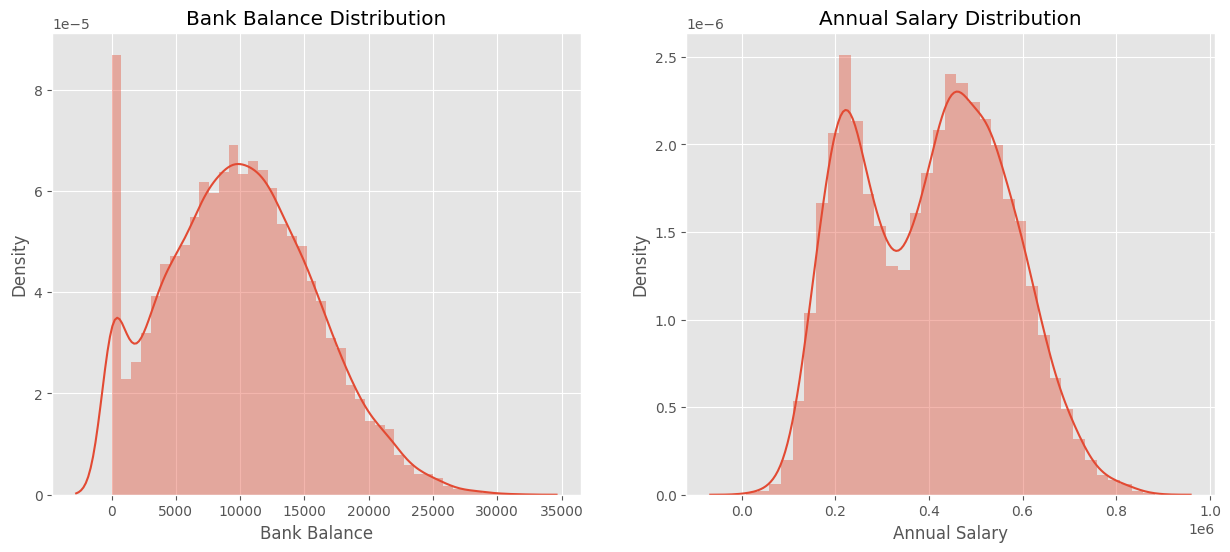

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax = ax.flatten()

for index, (col, axes) in enumerate(zip(num_col, ax)):
    sns.distplot(data[col], ax=axes)
    axes.set_title(f"{col.title()} Distribution")
plt.show()

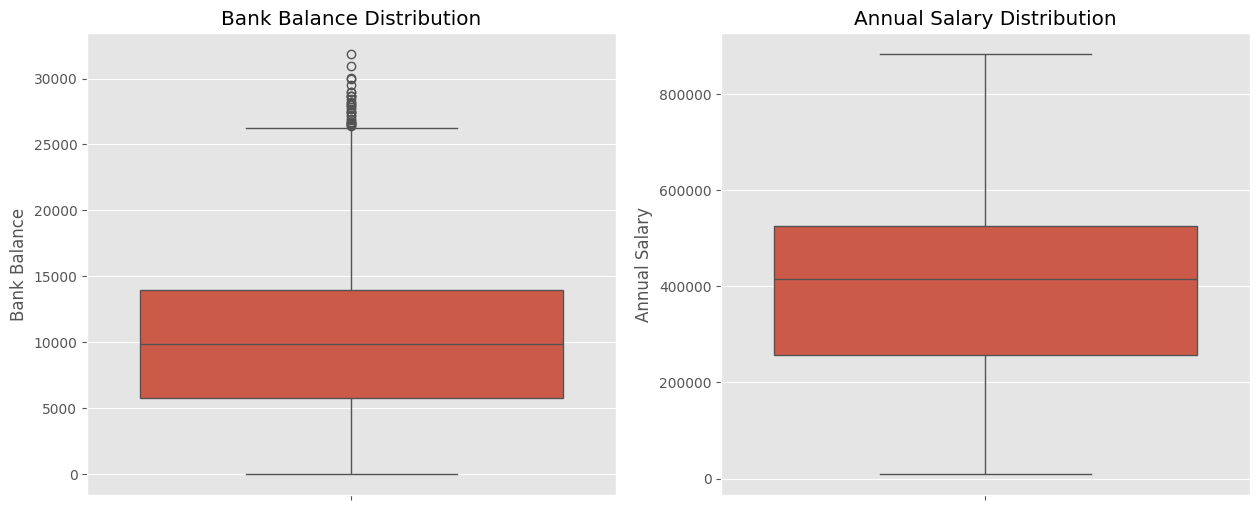

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax = ax.flatten()

for index, (col, axes) in enumerate(zip(num_col, ax)):
    sns.boxplot(data[col], ax=axes)
    axes.set_title(f"{col.title()} Distribution")
plt.show()

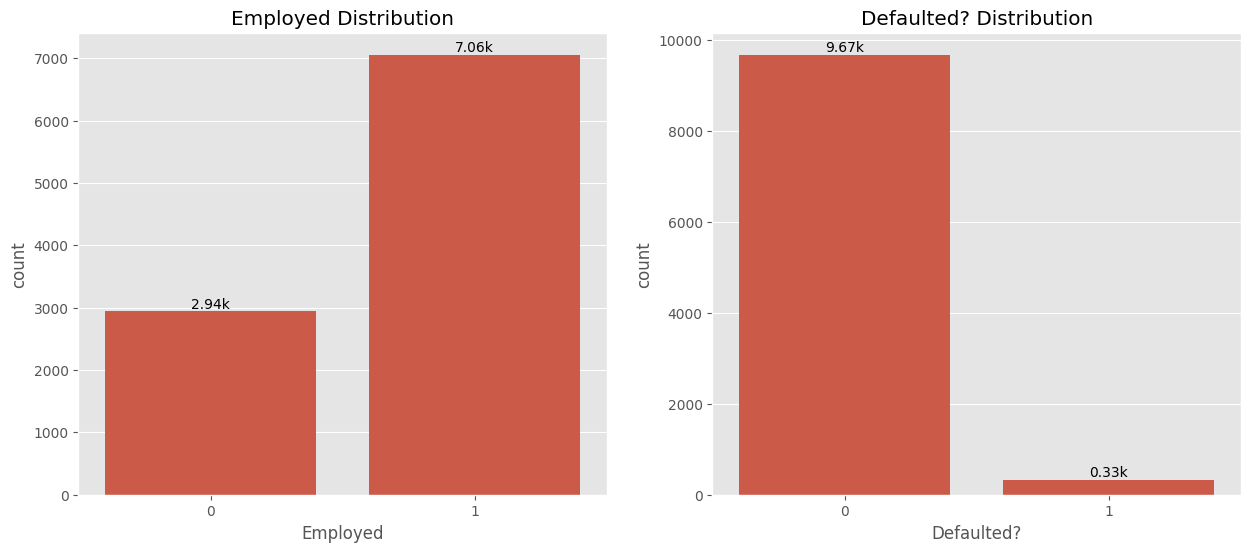

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax = ax.flatten()

for index, (col, axes) in enumerate(zip(cat_col, ax)):
    countplot = sns.countplot(x=data[col], ax=axes)
    countplot.set_title(f"{col.title()} Distribution")

    for p in countplot.patches:
        h = p.get_height()
        countplot.text(p.get_x()+(p.get_width()/2), h, f"{h/1000:.2f}k", va="bottom", ha="center")
plt.show()

## Observation:
* There seems to be an inbalance in the target distribution (Defaulted?)

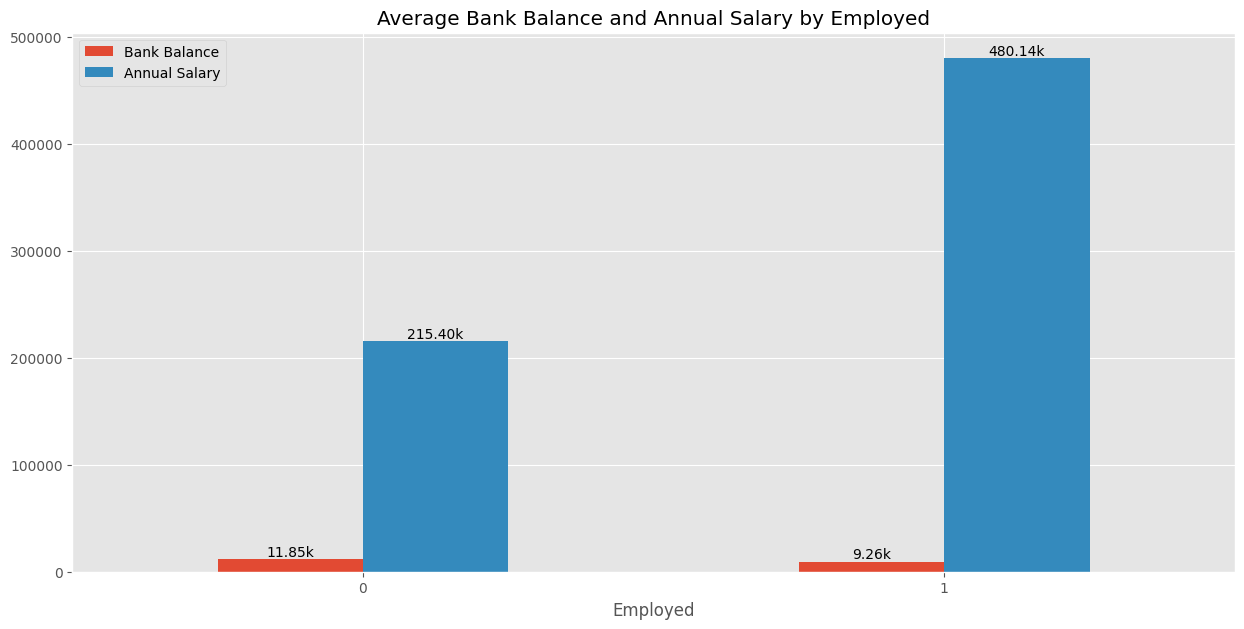

In [16]:
barplot = data.groupby("Employed").mean().drop("Defaulted?", axis=1).plot(kind="bar",
                                                                          figsize=(15, 7),
                                                                          title="Average Bank Balance and Annual Salary by Employed")

for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h/1000:.2f}k", va="bottom", ha="center")

barplot.set_xticklabels(labels=barplot.get_xticklabels(), rotation=360)
plt.show()

## Observation:
* The average annual salary of an unemployed person is 215.40k which is lesser than the average annual salary of a person who is employed
* The average bank balance of an unemployed person is 11.85k while that of an employed person is 9.26k

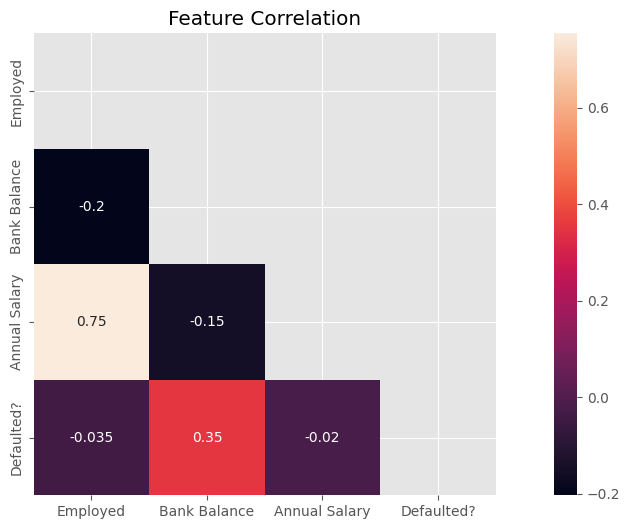

In [17]:
plt.figure(figsize=(15, 6))
sns.heatmap(data.corr(),
            annot=True,
            square=True,
            mask=np.triu(np.ones(data.corr().shape)))
plt.title("Feature Correlation")
plt.show()

## Split Data

In [18]:
X = data.drop("Defaulted?", axis=1)
y = data["Defaulted?"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, stratify=y, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=.7, stratify=y_test, random_state=0)

print(X_train.shape, X_test.shape, X_val.shape)

(7000, 3) (2100, 3) (900, 3)


## Train Algorithm (BaseLine Model)

In [20]:
XGB_reg = XGBClassifier()

XGB_reg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Model Evaluation

In [21]:
train_pred = XGB_reg.predict(X_train)

print(f"Train Prediction Accuracy: {accuracy_score(y_true=y_train, y_pred=train_pred)}")

Train Prediction Accuracy: 0.9841428571428571


In [22]:
test_pred = XGB_reg.predict(X_test)

print(f"Test Prediction Accuracy: {accuracy_score(y_true=y_test, y_pred=test_pred)}")

Test Prediction Accuracy: 0.9704761904761905


In [23]:
val_pred = XGB_reg.predict(X_val)

print(f"Validation Prediction Accuracy: {accuracy_score(y_true=y_val, y_pred=val_pred)}")

Validation Prediction Accuracy: 0.9733333333333334


## Stratified KFold Cross-Validation

In [24]:
def StratifiedKFoldCrossVal(X:pd.core.frame.DataFrame, y:pd.core.series.Series, n_splits:int=5):
    xgb_reg = XGBClassifier()
    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

    acc_score_train, acc_score_test = [], []

    # Split the dataset into Folds for training
    for (train_idx, test_idx) in tqdm(skf.split(X, y), desc="Training...", total=n_splits):
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        # Fit the Algorithm
        xgb_reg.fit(x_train, y_train)

        train_pred = xgb_reg.predict(x_train)
        test_pred = xgb_reg.predict(x_test)

        acc_score_train.append(accuracy_score(y_true=train_pred, y_pred=y_train))
        acc_score_test.append(accuracy_score(y_true=y_test, y_pred=test_pred))

    print(f"Train Prediction Accuracy: {np.mean(acc_score_train)}\nTest Prediction Accuracy: {np.mean(acc_score_test)}")

    return xgb_reg

In [25]:
xgb_model = StratifiedKFoldCrossVal(X_train, y_train)

Training...: 100%|██████████| 5/5 [00:00<00:00,  9.64it/s]

Train Prediction Accuracy: 0.985
Test Prediction Accuracy: 0.967


In [26]:
test_pred = xgb_model.predict(X_test)

print(f"Test Prediction Accuracy: {accuracy_score(y_true=y_test, y_pred=test_pred)}")

Test Prediction Accuracy: 0.969047619047619


In [27]:
val_pred = xgb_model.predict(X_val)

print(f"Validation Prediction Accuracy: {accuracy_score(y_true=y_val, y_pred=val_pred)}")

Validation Prediction Accuracy: 0.9722222222222222


## Classification Report

In [28]:
print(classification_report(y_true=y_val, y_pred=val_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       870
           1       0.69      0.30      0.42        30

    accuracy                           0.97       900
   macro avg       0.83      0.65      0.70       900
weighted avg       0.97      0.97      0.97       900



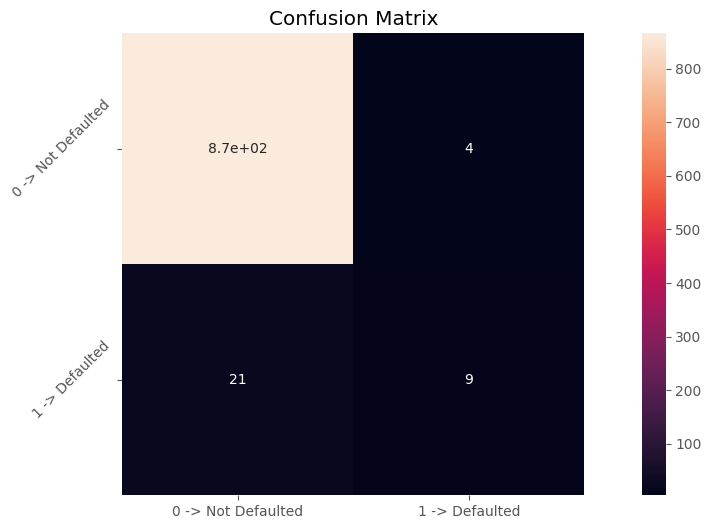

In [29]:
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(confusion_matrix(y_true=y_val, y_pred=val_pred), annot=True, square=True)
heatmap.set_xticklabels(["0 -> Not Defaulted", "1 -> Defaulted"])
heatmap.set_yticklabels(["0 -> Not Defaulted", "1 -> Defaulted"], rotation=45)
plt.title("Confusion Matrix")
plt.show()

## ROC AUC CURVE

In [30]:
def PLOT_ROC_AUC_CURVE(y_true, y_pred):
    fpr, tpr, treshold = roc_curve(y_true=y_true, y_score=y_pred)
    AUC_SCORE = auc(fpr, tpr)

    plt.figure(figsize=(15, 6))
    plt.plot(fpr, tpr, label=f"AUC_SCORE: {AUC_SCORE}")
    plt.plot([0, 1], [0, 1], ls="--",c="k")
    plt.title("ROC_AUC_CURVE")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

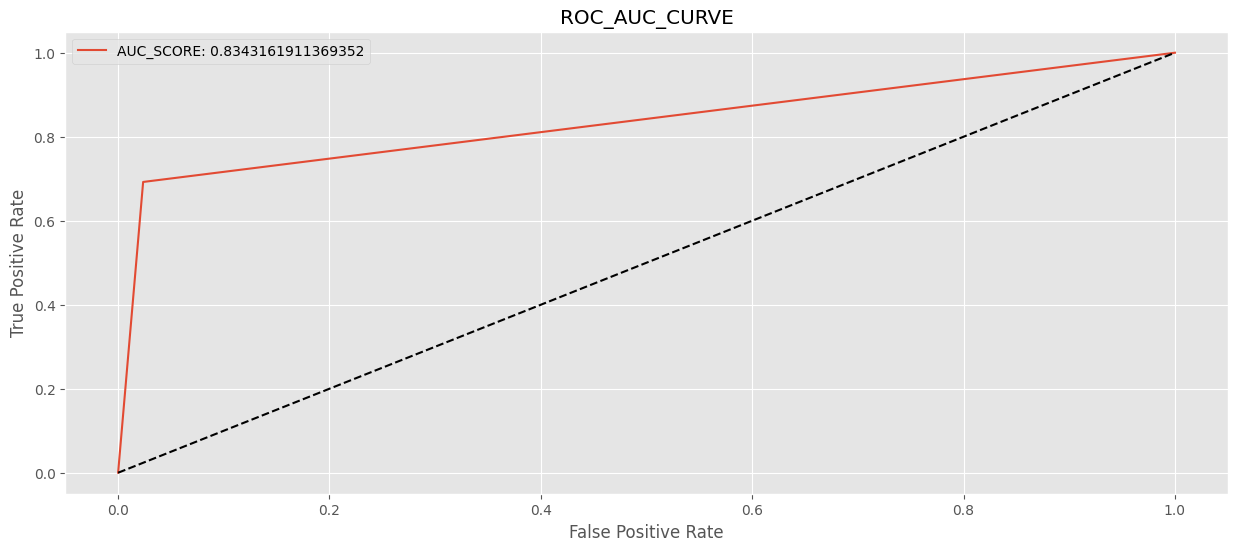

In [31]:
PLOT_ROC_AUC_CURVE(val_pred, y_val)

## KMean Clustering

In [32]:
cluster_data =  data.copy()

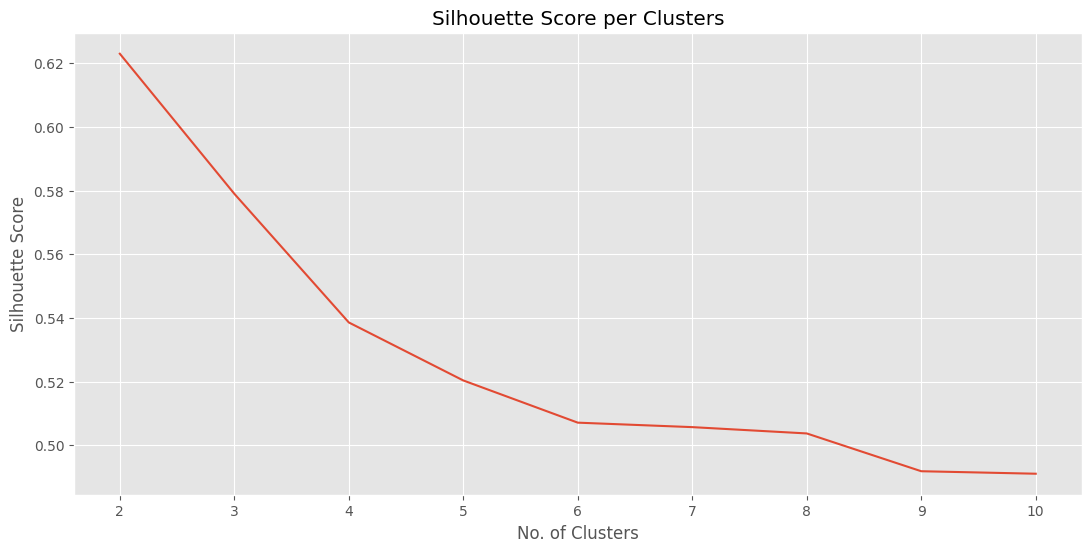

In [33]:
SILHOUETTE_SCORE = []
for i in range(2, 11):
    kmean = KMeans(n_clusters=i)
    kmean.fit(cluster_data)
    SILHOUETTE_SCORE.append(silhouette_score(X=cluster_data, labels=kmean.labels_))

plt.figure(figsize=(13, 6))
plt.plot(range(2, 11), SILHOUETTE_SCORE)
plt.xlabel("No. of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per Clusters")
plt.show()

## Observation:

Clustering won't be a good idea due to the low Silhouette score but it's worth giving a try.

## Upsampling Data

In [34]:
upsampler = RandomOverSampler(random_state=0)

X_resampled, y_resampled = upsampler.fit_resample(X, y)

X_resampled.shape

(19334, 3)

## Split data

In [35]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, train_size=.7, stratify=y_resampled, random_state=0)
X_test_resampled, X_val_resampled, y_test_resampled, y_val_resampled = train_test_split(X_test_resampled, y_test_resampled, train_size=.7, stratify=y_test_resampled, random_state=0)

print(X_train_resampled.shape, X_test_resampled.shape, X_val_resampled.shape)

(13533, 3) (4060, 3) (1741, 3)


In [36]:
xgb_model_upsampled = StratifiedKFoldCrossVal(X_train_resampled, y_train_resampled)

Training...: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]

Train Prediction Accuracy: 0.986071055435424
Test Prediction Accuracy: 0.97280672511195


In [37]:
test_pred_resampled = xgb_model_upsampled.predict(X_test_resampled)

print(f"Test Prediction Accuracy: {accuracy_score(y_true=y_test_resampled, y_pred=test_pred_resampled)}")

Test Prediction Accuracy: 0.9753694581280788


In [38]:
val_pred_resampled = xgb_model_upsampled.predict(X_val_resampled)

print(f"Validation Prediction Accuracy: {accuracy_score(y_true=y_val_resampled, y_pred=val_pred_resampled)}")

Validation Prediction Accuracy: 0.977599080987938


In [39]:
print(classification_report(y_true=y_val_resampled, y_pred=val_pred_resampled))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       871
           1       0.96      1.00      0.98       870

    accuracy                           0.98      1741
   macro avg       0.98      0.98      0.98      1741
weighted avg       0.98      0.98      0.98      1741



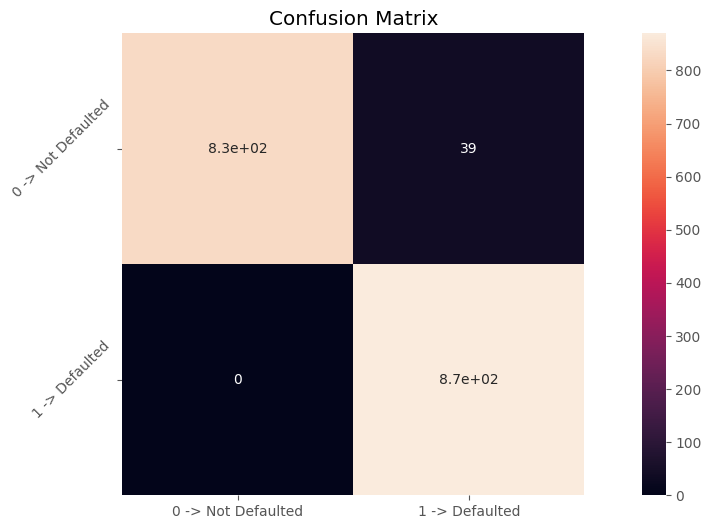

In [40]:
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(confusion_matrix(y_true=y_val_resampled, y_pred=val_pred_resampled), annot=True, square=True)
heatmap.set_xticklabels(["0 -> Not Defaulted", "1 -> Defaulted"])
heatmap.set_yticklabels(["0 -> Not Defaulted", "1 -> Defaulted"], rotation=45)
plt.title("Confusion Matrix")
plt.show()

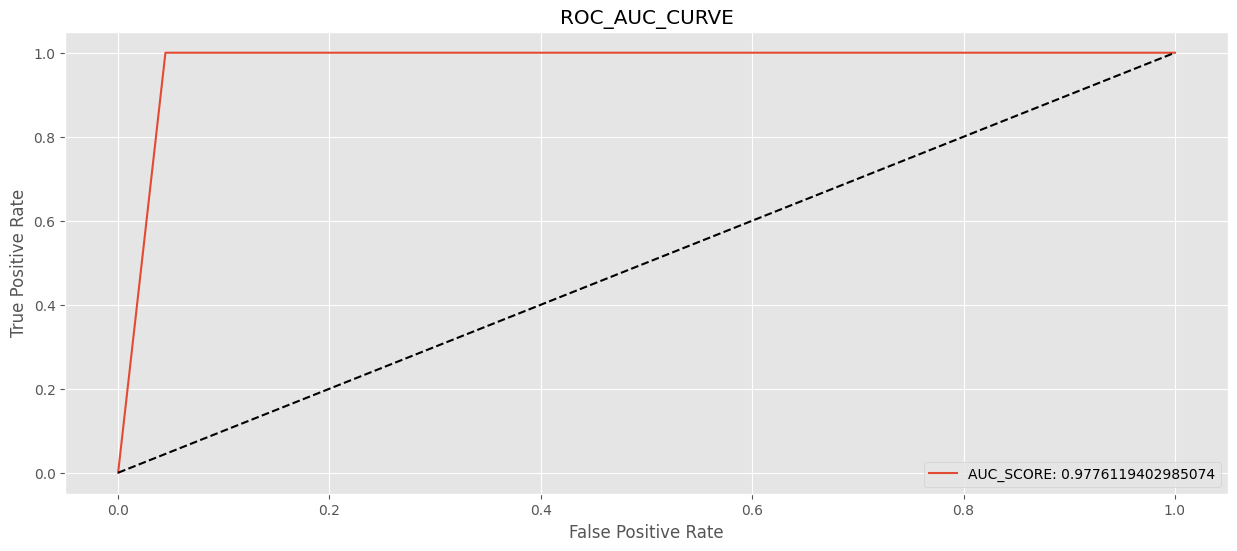

In [41]:
PLOT_ROC_AUC_CURVE(y_true=y_val_resampled, y_pred=val_pred_resampled)

## Observation:
- Upsampling the data helped the model improve in performance and also helped reduce bias in the models predictions

## Hyperparameter Optimization

In [42]:
def Objective(trials, X, y, n_splits):
    params = {
                "eta" : trials.suggest_uniform("eta", 0.01, 0.1),
                "gamma": trials.suggest_uniform("gamma", 0.05, 0.1),
                "max_depth": trials.suggest_int("max_depth", 100, 1000),
                "min_child_weight": trials.suggest_int("min_child_weight", 1, 10),
                "subsample": trials.suggest_uniform("subsample", 0.1, 1),
                "colsample_bytree":trials.suggest_uniform("colsample_bytree", 0.1, 1),
                "lambda": trials.suggest_uniform("lambda", 0.01, 0.1),
                "alpha": trials.suggest_uniform("alpha", 0, 1)
    }

    XGB_REG = XGBClassifier(**params)

    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

    acc_score_test = []

    # Split the dataset into Folds for training
    for (train_idx, test_idx) in skf.split(X, y):
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        # Fit the Algorithm
        XGB_REG.fit(x_train, y_train)

        test_pred = XGB_REG.predict(x_test)

        acc_score_test.append(accuracy_score(y_true=y_test, y_pred=test_pred))

    return np.mean(acc_score_test)

Obj_Func = partial(Objective, X=X_train_resampled, y=y_train_resampled, n_splits=5)
study = create_study(direction="maximize")

[I 2024-04-13 06:25:43,048] A new study created in memory with name: no-name-78096b65-4252-471c-ae3c-c76a00872c26


In [43]:
study.optimize(func=Obj_Func, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-04-13 06:25:43,930] Trial 0 finished with value: 0.9023127742779595 and parameters: {'eta': 0.02432224183467392, 'gamma': 0.06333244449433231, 'max_depth': 462, 'min_child_weight': 8, 'subsample': 0.6086979168581931, 'colsample_bytree': 0.40401963505923333, 'lambda': 0.09971855287827623, 'alpha': 0.9973916186173544}. Best is trial 0 with value: 0.9023127742779595.
[I 2024-04-13 06:25:46,857] Trial 1 finished with value: 0.9586932785739855 and parameters: {'eta': 0.07303854879604274, 'gamma': 0.051188914533130195, 'max_depth': 645, 'min_child_weight': 5, 'subsample': 0.6049064254899605, 'colsample_bytree': 0.8368626911111605, 'lambda': 0.04280292139381313, 'alpha': 0.745673091546256}. Best is trial 1 with value: 0.9586932785739855.
[I 2024-04-13 06:25:47,583] Trial 2 finished with value: 0.9119929142670544 and parameters: {'eta': 0.07431851223091031, 'gamma': 0.062198698254933356, 'max_depth': 173, 'min_child_weight': 6, 'subsample': 0.33415521564498, 'colsample_bytree': 0.61895

In [44]:
def StratifiedKFoldCrossVal(X:pd.core.frame.DataFrame, y:pd.core.series.Series, params:dict, n_splits:int=5):
    xgb_reg = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

    acc_score_train, acc_score_test = [], []

    # Split the dataset into Folds for training
    for (train_idx, test_idx) in tqdm(skf.split(X, y), desc="Training...", total=n_splits):
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        # Fit the Algorithm
        xgb_reg.fit(x_train, y_train)

        train_pred = xgb_reg.predict(x_train)
        test_pred = xgb_reg.predict(x_test)

        acc_score_train.append(accuracy_score(y_true=train_pred, y_pred=y_train))
        acc_score_test.append(accuracy_score(y_true=y_test, y_pred=test_pred))

    print(f"Train Prediction Accuracy: {np.mean(acc_score_train)}\nTest Prediction Accuracy: {np.mean(acc_score_test)}")

    return xgb_reg

In [45]:
print("Best Accuracy Score: {}".format(study.best_value))

Best Accuracy Score: 0.980270061658873


In [46]:
comb_x_train_resample = pd.concat([X_train_resampled, X_test_resampled])
comb_y_train_resample = pd.concat([y_train_resampled, y_test_resampled])

In [47]:
xgb_model_upsampled_optimized = StratifiedKFoldCrossVal(comb_x_train_resample, comb_y_train_resample, study.best_params)

Training...: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

Train Prediction Accuracy: 0.9960637785912624
Test Prediction Accuracy: 0.9826066439297044


In [48]:
val_pred_resampled_opt = xgb_model_upsampled_optimized.predict(X_val_resampled)

print(f"Validation Prediction Accuracy: {accuracy_score(y_true=y_val_resampled, y_pred=val_pred_resampled_opt)}")

Validation Prediction Accuracy: 0.9885123492245835


In [49]:
print(classification_report(y_true=y_val_resampled, y_pred=val_pred_resampled_opt))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       871
           1       0.98      1.00      0.99       870

    accuracy                           0.99      1741
   macro avg       0.99      0.99      0.99      1741
weighted avg       0.99      0.99      0.99      1741



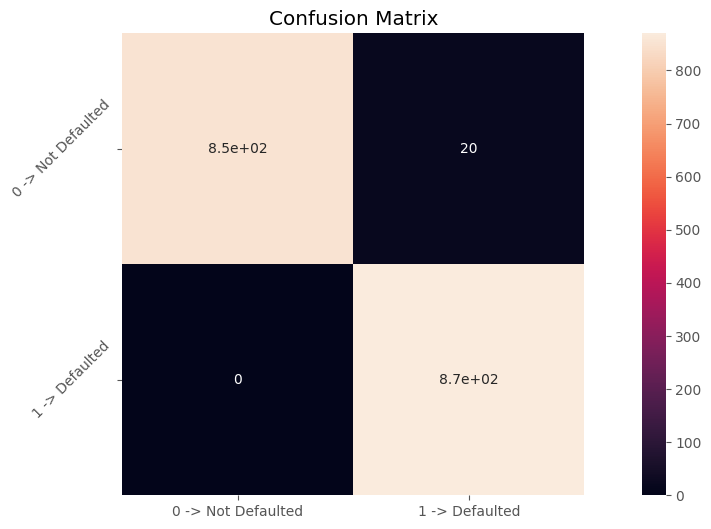

In [50]:
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(confusion_matrix(y_true=y_val_resampled, y_pred=val_pred_resampled_opt), annot=True, square=True)
heatmap.set_xticklabels(["0 -> Not Defaulted", "1 -> Defaulted"])
heatmap.set_yticklabels(["0 -> Not Defaulted", "1 -> Defaulted"], rotation=45)
plt.title("Confusion Matrix")
plt.show()

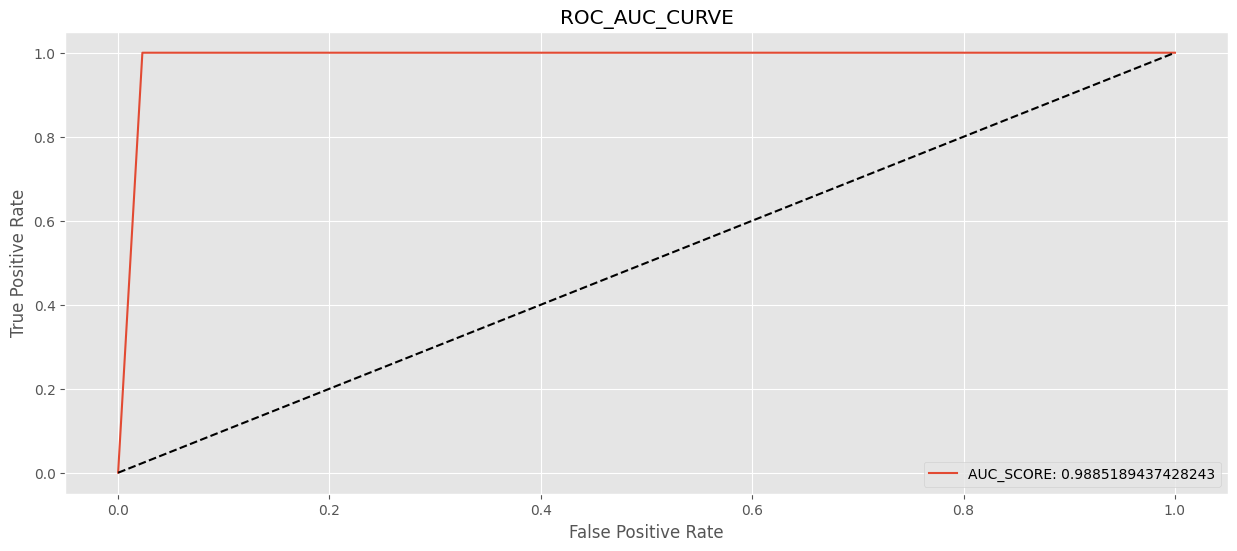

In [51]:
PLOT_ROC_AUC_CURVE(y_true=y_val_resampled, y_pred=val_pred_resampled_opt)

## Observation:
Hyperparameter Optimization Helped in improving the models performance.

In [52]:
# Display the columns needed by the model
print("Columns used for training: ", X.columns)

Columns used for training:  Index(['Employed', 'Bank Balance', 'Annual Salary'], dtype='object')


## Save Model

In [53]:
import pickle

# Open file
with open("Loan_default_pred.pkl", "wb") as model:
    # Save model
    pickle.dump(xgb_model_upsampled_optimized, model)

## The End

#### Code by Edifon Emmanuel Jimmy (Eddy)